In [1]:
!pip install tensorflow==2.12

**Dataset**

In [2]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-07-19 22:58:22--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.203.0, 52.217.192.152, 16.182.67.160, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.203.0|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  53.7MB/s    in 0.2s    

2024-07-19 22:58:22 (53.7 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Jena weather dataset**

In [3]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

line1 = data.split("\n")
header1 = line1[0].split(",")
line1 = line1[1:]
print(header1)
print(len(line1))

num_var = len(header1)
print("Number of variables:", num_var)
num_rows = len(line1)
print("Number of rows:", num_rows)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451
Number of variables: 15
Number of rows: 420451


**Dataset contains 420451 rows and 15 features**

**Following the data analysis, specific values are saved in the raw_data and temperature arrays for subsequent processing or analysis. Comma-separated values are converted into floating-point numbers.**

In [4]:
import numpy as np
temp1 = np.zeros((len(line1),))
raw_d = np.zeros((len(line1), len(header1) - 1))
for i, line in enumerate(line1):
    values = [float(x) for x in line.split(",")[1:]]
    temp1[i] = values[1]
    raw_d[i, :] = values[:]

The timeseries plot of temperature

Text(0, 0.5, 'Temperature')

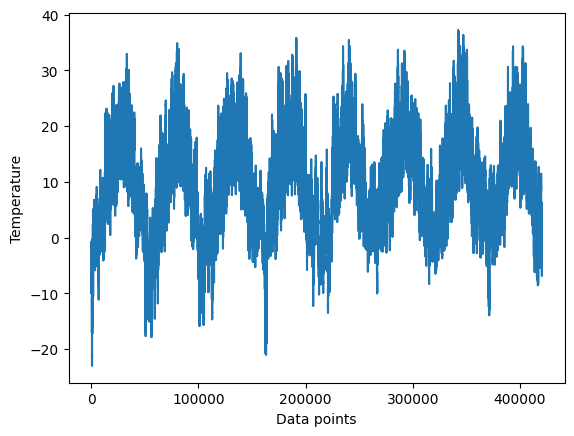

In [5]:
from matplotlib import pyplot as plt
plt.plot(range(len(temp1)), temp1)
plt.xlabel('Data points')
plt.ylabel('Temperature')

**The temperature time series for the first ten days is plotted. Since each day consists of 144 data points, ten days will produce a total of 1440 data points.**

Text(0, 0.5, 'Temperature')

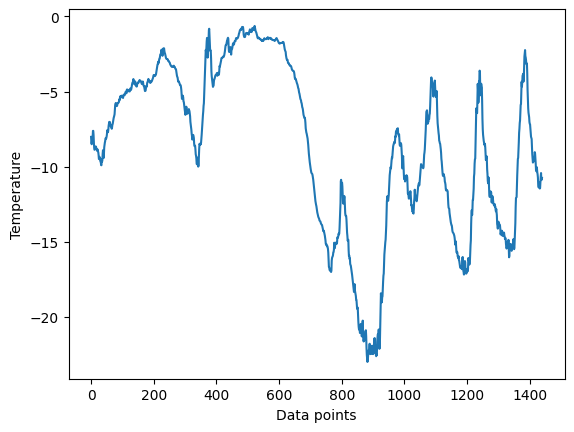

In [6]:
plt.plot(range(1440), temp1[:1440])
plt.xlabel('Data points')
plt.ylabel('Temperature')

**Calculating the number of samples needed for each data split, with 25% allocated for validation and 50% for training.**

In [7]:
num_of_train = int(0.5 * len(raw_d))
num_of_val= int(0.25 * len(raw_d))
num_of_test= len(raw_d) - num_of_train - num_of_val
print("Number of train samples:", num_of_train)
print("Number of validation samples:", num_of_val)
print("Number of test samples:", num_of_test)

Number of train samples: 210225
Number of validation samples: 105112
Number of test samples: 105114


**Getting the information ready**

**Since the data is already in numerical form, vectorization is unnecessary. However, it is important to standardize all variables due to differences in their scales (e.g., temperature ranges from -20 to +30, while pressure is measured in millibars).**

In [8]:
mean1 = raw_d[:num_of_train].mean(axis=0)
raw_d -= mean1
std = raw_d[:num_of_train].std(axis=0)
raw_d /= std

In [9]:
import numpy as np
from tensorflow import keras
int_sequence1 = np.arange(10)
dummy_d = keras.utils.timeseries_dataset_from_array(
    data=int_sequence1[:-3],
    targets=int_sequence1[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_d:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**It is essential to create separate training, validation, and testing datasets because of the significant duplication within the dataset. Allocating RAM for every sample would be inefficient, so samples will be generated in real-time instead.**

In [10]:
sample_rate = 6
sequencelength = 120
delay = sample_rate * (sequencelength + 24 - 1)
batch_size = 256

training_data = keras.utils.timeseries_dataset_from_array(
    raw_d[:-delay],
    targets=temp1[delay:],
    sampling_rate=sample_rate,
    sequence_length=sequencelength,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_of_train)

validation_data = keras.utils.timeseries_dataset_from_array(
    raw_d[:-delay],
    targets=temp1[delay:],
    sampling_rate=sample_rate,
    sequence_length=sequencelength,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_of_train,
    end_index=num_of_train + num_of_val)

testing_data = keras.utils.timeseries_dataset_from_array(
    raw_d[:-delay],
    targets=temp1[delay:],
    sampling_rate=sample_rate,
    sequence_length=sequencelength,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_of_train + num_of_val)

**Result of the databases**

In [11]:
for samples, targets in training_data:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


**A practical baseline not driven by machine learning:

Setting the baseline MAE involves using the final value in the input sequence as the starting point. The function "evaluate_naive_method" is defined for this purpose, providing a reference for evaluating the performance of a simple forecasting approach.**

In [12]:
def evaluate_naive_method(dataset):
    total_absolute_error = 0.
    samples_saw = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean1[1]
        total_absolute_error += np.sum(np.abs(preds - targets))
        samples_saw += samples.shape[0]
    return total_absolute_error / samples_saw

print(f"Validation MAE: {evaluate_naive_method(validation_data):.2f}")
print(f"Test MAE: {evaluate_naive_method(testing_data):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


**A straightforward approach is to predict that the temperature will stay the same over the next 24 hours. With this basic baseline, the test mean is 2.62 degrees Celsius, and the validation mean absolute error (MAE) is 2.44 degrees. In other words, if future temperatures were to remain constant, the average deviation from the actual temperature would be approximately 2.5 degrees.

Introduction to Machine Learning: Dense Layer

Training and evaluating a densely connected model.**

In [13]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequencelength, raw_d.shape[-1]))
G1 = layers.Flatten()(inputs)
G1 = layers.Dense(16, activation="relu")(G1)
outputs = layers.Dense(1)(G1)
model = keras.Model(inputs, outputs)

In [14]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])


history = model.fit(training_data, epochs=5,
                    validation_data = validation_data, callbacks=callbacks)

Epoch 1/5
819/819 [==============================] - 62s 75ms/step - loss: 11.8984 - mae: 2.6682 - val_loss: 10.4127 - val_mae: 2.5368
Epoch 2/5
819/819 [==============================] - 56s 68ms/step - loss: 8.7366 - mae: 2.3255 - val_loss: 10.5348 - val_mae: 2.5662
Epoch 3/5
819/819 [==============================] - 55s 66ms/step - loss: 8.0174 - mae: 2.2298 - val_loss: 12.1098 - val_mae: 2.7483
Epoch 4/5
819/819 [==============================] - 56s 67ms/step - loss: 7.6246 - mae: 2.1747 - val_loss: 12.4215 - val_mae: 2.7777
Epoch 5/5
819/819 [==============================] - 58s 71ms/step - loss: 7.3286 - mae: 2.1310 - val_loss: 10.3855 - val_mae: 2.5385


In [15]:
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 18s 44ms/step - loss: 11.1121 - mae: 2.6466
Test MAE: 2.65


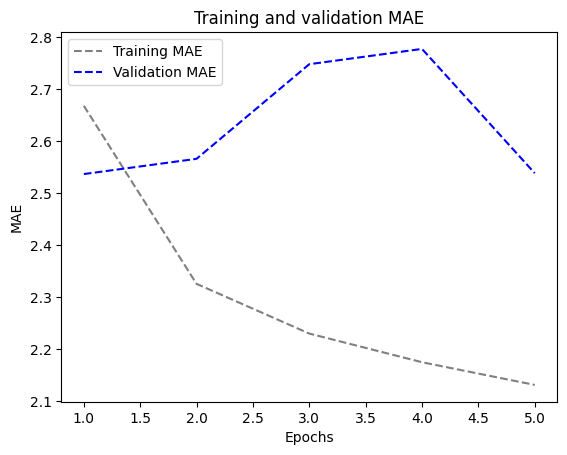

In [16]:
import matplotlib.pyplot as plt
loss1 = history.history["mae"]
validation_loss = history.history["val_mae"]

epochs = range(1, len(loss1) + 1)
plt.figure()
plt.plot(epochs, loss1, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**1D convolutional model.**

In [17]:
inputs = keras.Input(shape=(sequencelength, raw_d.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [18]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history1D = model.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                    callbacks=callbacks)

model_to_dot = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(testing_data)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 114s 137ms/step - loss: 21.4170 - mae: 3.6523 - val_loss: 17.0639 - val_mae: 3.2661
Epoch 2/5
819/819 [==============================] - 92s 112ms/step - loss: 15.6015 - mae: 3.1457 - val_loss: 14.1088 - val_mae: 2.9623
Epoch 3/5
819/819 [==============================] - 90s 110ms/step - loss: 14.1345 - mae: 2.9893 - val_loss: 14.1238 - val_mae: 2.9549
Epoch 4/5
819/819 [==============================] - 98s 119ms/step - loss: 13.1210 - mae: 2.8755 - val_loss: 13.5641 - val_mae: 2.8951
Epoch 5/5
405/405 [==============================] - 22s 53ms/step - loss: 15.5466 - mae: 3.1669
Test MAE: 3.17


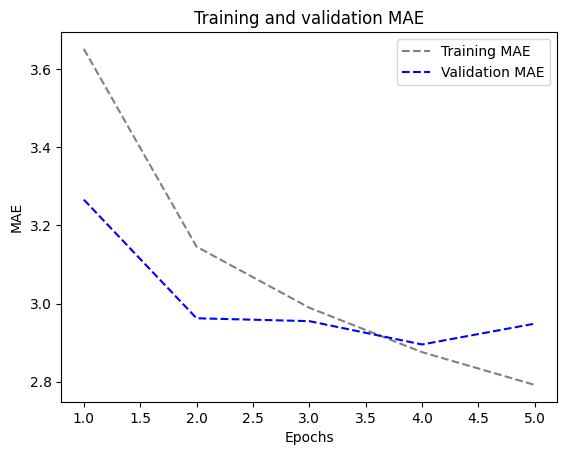

In [19]:
import matplotlib.pyplot as plt
loss1D = history1D.history["mae"]
validation_loss1D = history1D.history["val_mae"]

epochs = range(1, len(loss1D) + 1)
plt.figure()
plt.plot(epochs, loss1D, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss1D, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**Convolutional data seems to perform worse than dense models or common-sense approaches. This may be due to:**

Weather data does not satisfy the translation invariance assumption. The order in which information is presented is crucial. For predicting the temperature for the next day, recent historical data is significantly more relevant than data from many days prior. Unfortunately, a 1D convolutional neural network cannot adequately represent this important temporal order.

A Basic RNN:

1. An RNN layer capable of handling sequences of any length.

In [20]:
the_features = 14
input_RNN = keras.Input(shape=(None, the_features))
output_RNN = layers.SimpleRNN(16)(input_RNN)

models_RNN = keras.Model(input_RNN, output_RNN)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimRNN.keras",
                                    save_best_only=True)
]
models_RNN.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_RNN = models_RNN.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                    callbacks=callbacks)

models_RNN = keras.models.load_model("jena_SimRNN.keras")
print(f"Test MAE: {models_RNN.evaluate(testing_data)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 80s 95ms/step - loss: 138.6137 - mae: 9.6887 - val_loss: 144.0502 - val_mae: 9.9051
Epoch 2/5
819/819 [==============================] - 80s 97ms/step - loss: 136.4938 - mae: 9.5668 - val_loss: 143.7798 - val_mae: 9.8788
Epoch 3/5
819/819 [==============================] - 81s 98ms/step - loss: 136.3223 - mae: 9.5527 - val_loss: 143.7296 - val_mae: 9.8744
Epoch 4/5
819/819 [==============================] - 82s 100ms/step - loss: 136.2020 - mae: 9.5409 - val_loss: 143.6409 - val_mae: 9.8623
Epoch 5/5
405/405 [==============================] - 21s 51ms/step - loss: 151.3202 - mae: 9.9222
Test MAE: 9.92


**2.Simple RNN - Stacking RNN layers**

In [21]:
the_features2 = 14
steps = 120
inpu2 = keras.Input(shape=(steps, the_features2))
a = layers.SimpleRNN(16, return_sequences=True)(inpu2)
a = layers.SimpleRNN(16, return_sequences=True)(a)
outpu2 = layers.SimpleRNN(16)(a)
models2 = keras.Model(inpu2, outpu2)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SRNN2.keras",
                                    save_best_only=True)
]
models2.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history2 = models2.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                    callbacks=callbacks)

models2 = keras.models.load_model("jena_SRNN2.keras")
print(f"Test MAE: {models2.evaluate(testing_data)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 158s 188ms/step - loss: 136.7013 - mae: 9.5650 - val_loss: 143.4717 - val_mae: 9.8451
Epoch 2/5
819/819 [==============================] - 154s 188ms/step - loss: 136.0209 - mae: 9.5212 - val_loss: 143.4275 - val_mae: 9.8392
Epoch 3/5
819/819 [==============================] - 145s 177ms/step - loss: 135.9623 - mae: 9.5143 - val_loss: 143.3856 - val_mae: 9.8320
Epoch 4/5
819/819 [==============================] - 143s 174ms/step - loss: 135.9179 - mae: 9.5078 - val_loss: 143.4135 - val_mae: 9.8369
Epoch 5/5
405/405 [==============================] - 33s 79ms/step - loss: 151.1238 - mae: 9.9046
Test MAE: 9.90


**Simple GRU (Gated Recurrent Unit)**

In [22]:
inputs_GRU = keras.Input(shape=(sequencelength, raw_d.shape[-1]))
b = layers.GRU(16)(inputs_GRU)
outputs_GRU = layers.Dense(1)(b)
models_GRU = keras.Model(inputs_GRU, outputs_GRU)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras",
                                    save_best_only=True)
]
models_GRU.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_GRU = models_GRU.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                    callbacks=callbacks)

models_GRU = keras.models.load_model("jena_gru.keras")
print(f"Test MAE: {models_GRU.evaluate(testing_data)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 140s 167ms/step - loss: 38.3551 - mae: 4.4818 - val_loss: 12.5438 - val_mae: 2.6690
Epoch 2/5
819/819 [==============================] - 117s 143ms/step - loss: 10.4565 - mae: 2.5196 - val_loss: 9.5796 - val_mae: 2.3864
Epoch 3/5
819/819 [==============================] - 137s 167ms/step - loss: 9.4895 - mae: 2.4069 - val_loss: 9.5245 - val_mae: 2.3741
Epoch 4/5
819/819 [==============================] - 137s 166ms/step - loss: 9.1913 - mae: 2.3659 - val_loss: 9.6795 - val_mae: 2.3810
Epoch 5/5
405/405 [==============================] - 28s 67ms/step - loss: 10.2381 - mae: 2.5054
Test MAE: 2.51


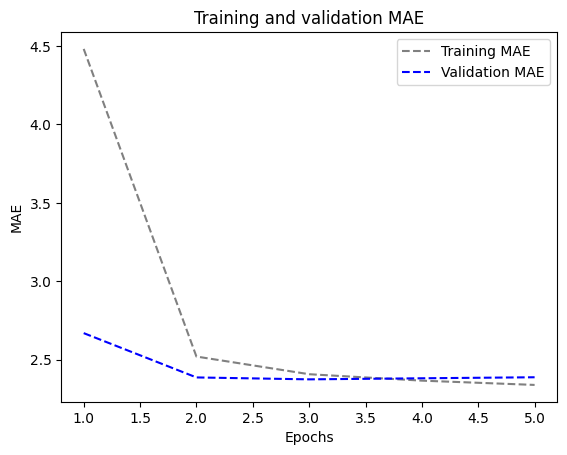

In [23]:
import matplotlib.pyplot as plt
loss_GRU = history_GRU.history["mae"]
validation_loss_GRU = history_GRU.history["val_mae"]

epochs = range(1, len(loss_GRU) + 1)
plt.figure()
plt.plot(epochs, loss_GRU, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_GRU, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()


**LSTM(Long Short-Term Memory )**

**1.LSTM-Simple**

In [24]:
inputs_LSTMS = keras.Input(shape=(sequencelength, raw_d.shape[-1]))
c = layers.LSTM(16)(inputs_LSTMS)
output_LSTMS = layers.Dense(1)(c)
model_LSTMS = keras.Model(inputs_LSTMS, output_LSTMS)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model_LSTMS.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_LSTMS = model_LSTMS.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/5
819/819 [==============================] - 125s 148ms/step - loss: 35.7270 - mae: 4.3400 - val_loss: 12.3005 - val_mae: 2.6789
Epoch 2/5
819/819 [==============================] - 118s 144ms/step - loss: 10.9732 - mae: 2.5748 - val_loss: 10.5526 - val_mae: 2.4558
Epoch 3/5
819/819 [==============================] - 134s 163ms/step - loss: 9.8415 - mae: 2.4549 - val_loss: 10.7621 - val_mae: 2.4661
Epoch 4/5
819/819 [==============================] - 123s 150ms/step - loss: 9.4615 - mae: 2.4067 - val_loss: 10.4657 - val_mae: 2.4372
Epoch 5/5
819/819 [==============================] - 119s 145ms/step - loss: 9.1633 - mae: 2.3711 - val_loss: 10.5230 - val_mae: 2.4537


In [25]:
model_LSTMS = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model_LSTMS.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 31s 75ms/step - loss: 10.9850 - mae: 2.5772
Test MAE: 2.58


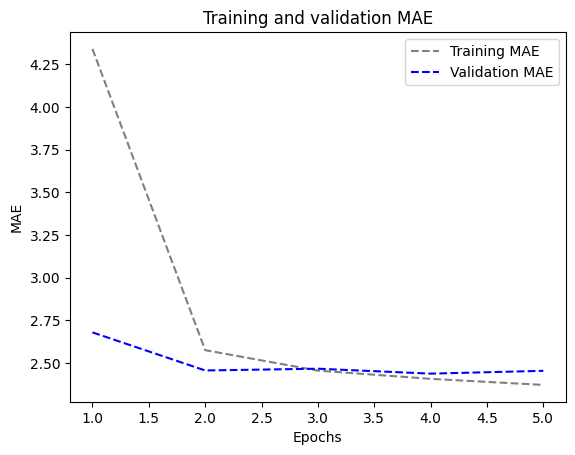

In [26]:
import matplotlib.pyplot as plt
loss_LSTMS = history_LSTMS.history["mae"]
validation_loss_LSTMS = history_LSTMS.history["val_mae"]

epochs = range(1, len(loss_LSTMS) + 1)
plt.figure()
plt.plot(epochs, loss_LSTMS, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_LSTMS, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**2.LSTM - dropout Regularization**

In [27]:
input_LSTMR = keras.Input(shape=(sequencelength, raw_d.shape[-1]))
d = layers.LSTM(16, recurrent_dropout=0.25)(input_LSTMR )
d = layers.Dropout(0.5)(d)
output_LSTMR = layers.Dense(1)(d)
model_LSTMR = keras.Model(input_LSTMR , output_LSTMR )

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model_LSTMR.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_LSTMR = model_LSTMR.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/5
819/819 [==============================] - 191s 229ms/step - loss: 46.5135 - mae: 5.0684 - val_loss: 13.0774 - val_mae: 2.7435
Epoch 2/5
819/819 [==============================] - 188s 230ms/step - loss: 20.0744 - mae: 3.4541 - val_loss: 9.8560 - val_mae: 2.4449
Epoch 3/5
819/819 [==============================] - 194s 237ms/step - loss: 18.4397 - mae: 3.3087 - val_loss: 9.6855 - val_mae: 2.4266
Epoch 4/5
819/819 [==============================] - 187s 228ms/step - loss: 17.5101 - mae: 3.2237 - val_loss: 9.6303 - val_mae: 2.4199
Epoch 5/5
819/819 [==============================] - 186s 227ms/step - loss: 16.8144 - mae: 3.1579 - val_loss: 9.5623 - val_mae: 2.4148


In [28]:
model_LSTMR = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model_LSTMR.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 31s 76ms/step - loss: 11.2013 - mae: 2.6277
Test MAE: 2.63


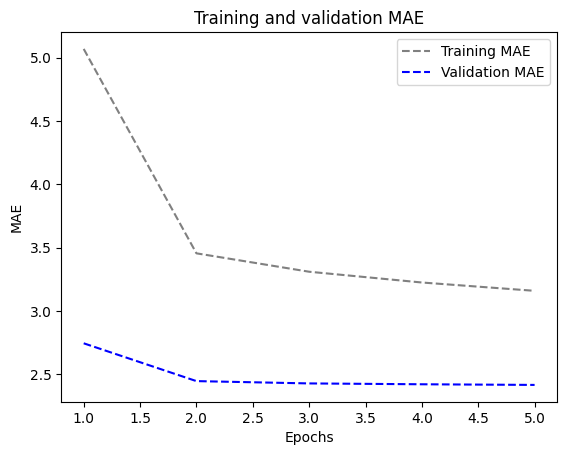

In [29]:
import matplotlib.pyplot as plt
loss_LSTMR = history_LSTMR .history["mae"]
validation_loss_LSTMR = history_LSTMR .history["val_mae"]

epochs = range(1, len(loss_LSTMR) + 1)
plt.figure()
plt.plot(epochs, loss_LSTMR, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_LSTMR, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**3.LSTM - Stacked setup with 16 units**

In [30]:
input_16 = keras.Input(shape=(sequencelength, raw_d.shape[-1]))
e = layers.LSTM(16, return_sequences=True)(input_16)
e = layers.LSTM(16)(e)
output_16 = layers.Dense(1)(e)
model_16 = keras.Model(input_16, output_16)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked1.keras",
                                    save_best_only=True)
]
model_16.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_16 = model_16.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/5
819/819 [==============================] - 204s 242ms/step - loss: 34.6623 - mae: 4.2848 - val_loss: 12.3141 - val_mae: 2.6937
Epoch 2/5
819/819 [==============================] - 195s 238ms/step - loss: 10.0681 - mae: 2.4668 - val_loss: 9.9165 - val_mae: 2.4686
Epoch 3/5
819/819 [==============================] - 196s 239ms/step - loss: 8.7171 - mae: 2.3039 - val_loss: 9.9251 - val_mae: 2.4825
Epoch 4/5
819/819 [==============================] - 194s 236ms/step - loss: 8.0360 - mae: 2.2119 - val_loss: 10.4227 - val_mae: 2.5373
Epoch 5/5
819/819 [==============================] - 196s 239ms/step - loss: 7.4948 - mae: 2.1350 - val_loss: 11.0109 - val_mae: 2.6135


In [31]:
model_16 = keras.models.load_model("jena_LSTM_stacked1.keras")
print(f"Test MAE: {model_16.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 48s 113ms/step - loss: 11.4072 - mae: 2.6215
Test MAE: 2.62


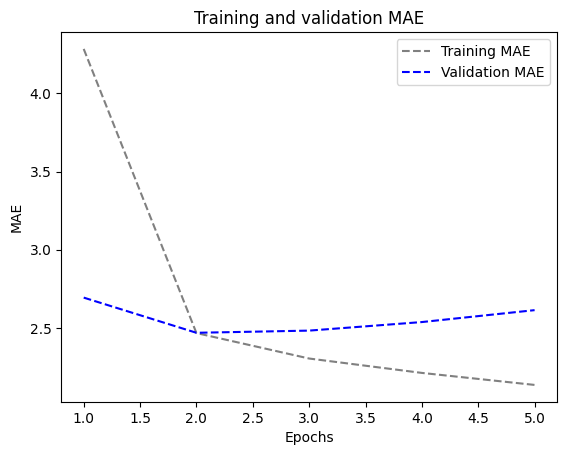

In [32]:
import matplotlib.pyplot as plt
loss_16 = history_16.history["mae"]
validation_loss_16 = history_16.history["val_mae"]

epochs = range(1, len(loss_16) + 1)
plt.figure()
plt.plot(epochs, loss_16, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_16, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()


**4.LSTM - Stacked setup with 32 units**

In [33]:
input_32 = keras.Input(shape=(sequencelength, raw_d.shape[-1]))
f = layers.LSTM(32, return_sequences=True)(input_32)
f = layers.LSTM(32)(f)
output_32 = layers.Dense(1)(f)
model_32 = keras.Model(input_32, output_32)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked2.keras",
                                    save_best_only=True)
]
model_32.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_32 = model_32.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/5
819/819 [==============================] - 284s 341ms/step - loss: 23.4409 - mae: 3.4376 - val_loss: 10.5010 - val_mae: 2.5203
Epoch 2/5
819/819 [==============================] - 276s 337ms/step - loss: 7.9627 - mae: 2.1972 - val_loss: 11.0106 - val_mae: 2.6200
Epoch 3/5
819/819 [==============================] - 319s 390ms/step - loss: 6.4367 - mae: 1.9671 - val_loss: 11.2705 - val_mae: 2.6453
Epoch 4/5
819/819 [==============================] - 310s 378ms/step - loss: 5.4211 - mae: 1.8009 - val_loss: 12.1361 - val_mae: 2.7620
Epoch 5/5
819/819 [==============================] - 306s 373ms/step - loss: 4.5406 - mae: 1.6479 - val_loss: 12.8525 - val_mae: 2.8507


In [34]:
model_32 = keras.models.load_model("jena_LSTM_stacked2.keras")
print(f"Test MAE: {model_32.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 57s 134ms/step - loss: 11.5211 - mae: 2.6479
Test MAE: 2.65


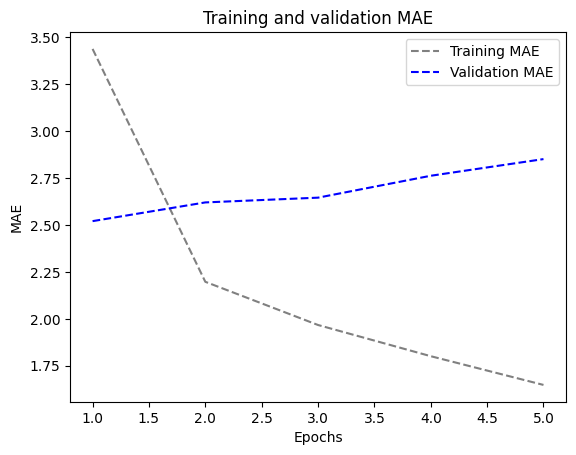

In [35]:
import matplotlib.pyplot as plt
loss_32 = history_32.history["mae"]
validation_loss_32 = history_32.history["val_mae"]

epochs = range(1, len(loss_32) + 1)
plt.figure()
plt.plot(epochs, loss_32, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_32, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**5.LSTM - Stacked setup with 8 units**

In [36]:
input_8u = keras.Input(shape=(sequencelength, raw_d.shape[-1]))
h = layers.LSTM(8, return_sequences=True)(input_8u)
h = layers.LSTM(8)(h)
output_8u = layers.Dense(1)(h)
model_8u = keras.Model(input_8u, output_8u)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked3.keras",
                                    save_best_only=True)
]
model_8u.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_8u = model_8u.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/5
819/819 [==============================] - 168s 199ms/step - loss: 75.3414 - mae: 6.6791 - val_loss: 39.8268 - val_mae: 4.7129
Epoch 2/5
819/819 [==============================] - 167s 204ms/step - loss: 23.3653 - mae: 3.5553 - val_loss: 13.8140 - val_mae: 2.7665
Epoch 3/5
819/819 [==============================] - 169s 206ms/step - loss: 11.4668 - mae: 2.6160 - val_loss: 10.4425 - val_mae: 2.4838
Epoch 4/5
819/819 [==============================] - 163s 198ms/step - loss: 9.8009 - mae: 2.4396 - val_loss: 9.8096 - val_mae: 2.4257
Epoch 5/5
819/819 [==============================] - 166s 203ms/step - loss: 9.3328 - mae: 2.3790 - val_loss: 9.6865 - val_mae: 2.4121


In [37]:
model_8u = keras.models.load_model("jena_LSTM_stacked3.keras")
print(f"Test MAE: {model_8u.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 34s 80ms/step - loss: 10.5611 - mae: 2.5446
Test MAE: 2.54


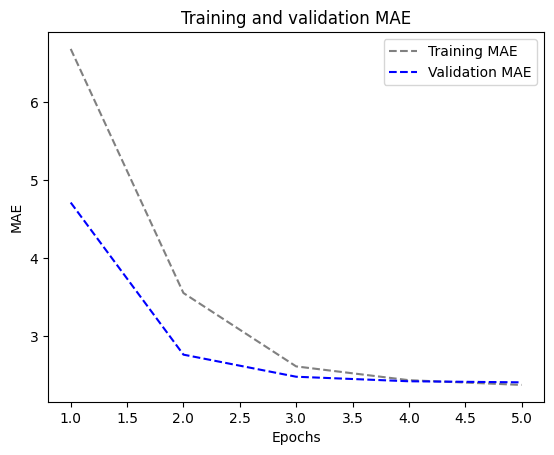

In [38]:
import matplotlib.pyplot as plt
loss_8u = history_8u.history["mae"]
validation_loss_8u = history_8u.history["val_mae"]

epochs = range(1, len(loss_8u) + 1)
plt.figure()
plt.plot(epochs, loss_8u, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_8u, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**6.LSTM - dropout-regularized, stacked model**

In [39]:
inputs = keras.Input(shape=(sequencelength, raw_d.shape[-1]))
i = layers.LSTM(8, recurrent_dropout=0.5, return_sequences=True)(inputs)
i = layers.LSTM(8, recurrent_dropout=0.5)(i)
i = layers.Dropout(0.5)(i)
outputs = layers.Dense(1)(i)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_LSTM_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/5
819/819 [==============================] - 298s 357ms/step - loss: 70.8341 - mae: 6.4512 - val_loss: 33.1843 - val_mae: 4.2534
Epoch 2/5
819/819 [==============================] - 282s 343ms/step - loss: 31.1402 - mae: 4.1663 - val_loss: 14.1205 - val_mae: 2.8257
Epoch 3/5
819/819 [==============================] - 282s 344ms/step - loss: 24.3762 - mae: 3.7338 - val_loss: 11.3885 - val_mae: 2.5912
Epoch 4/5
819/819 [==============================] - 293s 357ms/step - loss: 22.3891 - mae: 3.5878 - val_loss: 10.2776 - val_mae: 2.4750
Epoch 5/5
819/819 [==============================] - 283s 345ms/step - loss: 21.2213 - mae: 3.4963 - val_loss: 10.0852 - val_mae: 2.4643


In [40]:
model_r = keras.models.load_model("jena_stacked_LSTM_dropout.keras")
print(f"Test MAE: {model_r.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 38s 92ms/step - loss: 11.5611 - mae: 2.6300
Test MAE: 2.63


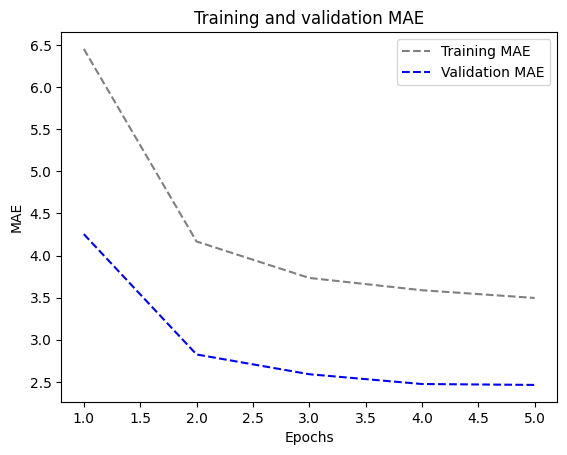

In [41]:
import matplotlib.pyplot as plt
loss_r = history.history["mae"]
validation_loss_r = history.history["val_mae"]

epochs = range(1, len(loss_r) + 1)
plt.figure()
plt.plot(epochs, loss_r, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_r, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**Bidirectional LSTM**

In [42]:
inputs = keras.Input(shape=(sequencelength, raw_d.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirec_LSTM.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history.bi = model.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                     callbacks=callbacks)

Epoch 1/5
819/819 [==============================] - 182s 215ms/step - loss: 26.2527 - mae: 3.6902 - val_loss: 10.6478 - val_mae: 2.5292
Epoch 2/5
819/819 [==============================] - 175s 213ms/step - loss: 9.6476 - mae: 2.4232 - val_loss: 9.5732 - val_mae: 2.3790
Epoch 3/5
819/819 [==============================] - 173s 211ms/step - loss: 8.8768 - mae: 2.3187 - val_loss: 9.5497 - val_mae: 2.3747
Epoch 4/5
819/819 [==============================] - 183s 222ms/step - loss: 8.3790 - mae: 2.2525 - val_loss: 9.8705 - val_mae: 2.4321
Epoch 5/5
819/819 [==============================] - 174s 212ms/step - loss: 7.9895 - mae: 2.2013 - val_loss: 10.1077 - val_mae: 2.4470


In [43]:
model_bi = keras.models.load_model("jena_bidirec_LSTM.keras")
print(f"Test MAE: {model_bi.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 36s 85ms/step - loss: 10.1580 - mae: 2.5069
Test MAE: 2.51


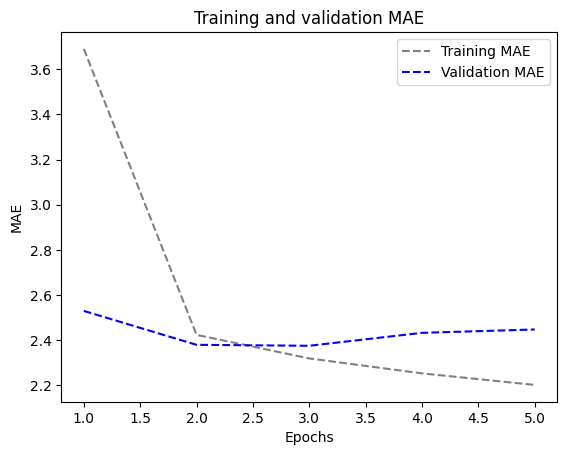

In [44]:
import matplotlib.pyplot as plt
loss_bi = history.bi.history["mae"]
validation_loss_bi = history.bi.history["val_mae"]

epochs = range(1, len(loss_bi) + 1)
plt.figure()
plt.plot(epochs, loss_bi, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_bi, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**1D Convnets and LSTM togther**

In [45]:
input_final = keras.Input(shape=(sequencelength, raw_d.shape[-1]))
l = layers.Conv1D(64, 3, activation='relu')(input_final)
l = layers.MaxPooling1D(3)(l)
l = layers.Conv1D(128, 3, activation='relu')(l)
l = layers.GlobalMaxPooling1D()(l)
l = layers.Reshape((-1, 128))(l)  # Reshape the data to be 3D
l = layers.LSTM(16)(l)
output_final = layers.Dense(1)(l)
model_final = keras.Model(input_final, output_final)

model_final.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_Conv_LSTM.keras", save_best_only=True)
]

history_final = model_final.fit(training_data, epochs=5, validation_data=validation_data, callbacks=callbacks)

Epoch 1/5
819/819 [==============================] - 136s 162ms/step - loss: 46.8331 - mae: 5.1126 - val_loss: 25.6545 - val_mae: 3.9195
Epoch 2/5
819/819 [==============================] - 130s 158ms/step - loss: 17.3885 - mae: 3.2279 - val_loss: 23.7813 - val_mae: 3.8362
Epoch 3/5
819/819 [==============================] - 129s 157ms/step - loss: 14.3491 - mae: 2.9393 - val_loss: 25.5126 - val_mae: 3.9770
Epoch 4/5
819/819 [==============================] - 131s 159ms/step - loss: 12.6512 - mae: 2.7518 - val_loss: 26.2255 - val_mae: 4.1048
Epoch 5/5
819/819 [==============================] - 148s 180ms/step - loss: 11.5283 - mae: 2.6206 - val_loss: 25.1719 - val_mae: 4.0286


In [46]:
model_final = keras.models.load_model("jena_Conv_LSTM.keras")
print(f"Test MAE: {model_final.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 28s 67ms/step - loss: 26.1324 - mae: 3.9975
Test MAE: 4.00


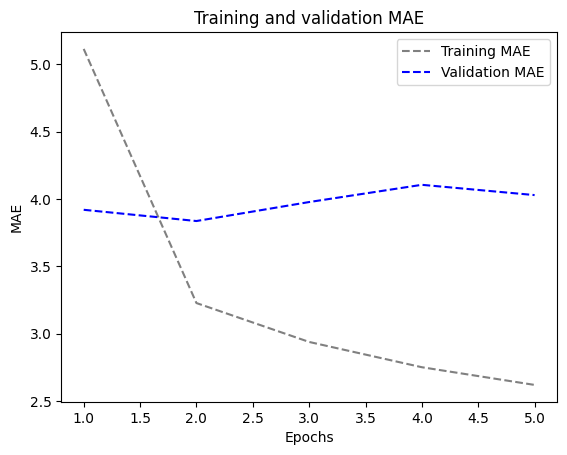

In [47]:
import matplotlib.pyplot as plt
loss_final = history_final.history["mae"]
validation_loss_final = history_final.history["val_mae"]

epochs = range(1, len(loss_final) + 1)
plt.figure()
plt.plot(epochs, loss_final, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_final, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

Models Built: Following are the details;

Common-sense, non-machine-learning baseline

A basic machine-learning model

1D convolutional model

Simple RNN layer that can process sequences of any length

Simple RNN - Stacking RNN layers

A Simple GRU (Gated Recurrent Unit)

LSTM-Simple

LSTM - dropout Regularization

Stacked setup with 16 units

Stacked setup with 32 units

Stacked setup with 8 units

LSTM - dropout-regularized, stacked

Bidirectional LSTM

1D Convnets and LSTM togther

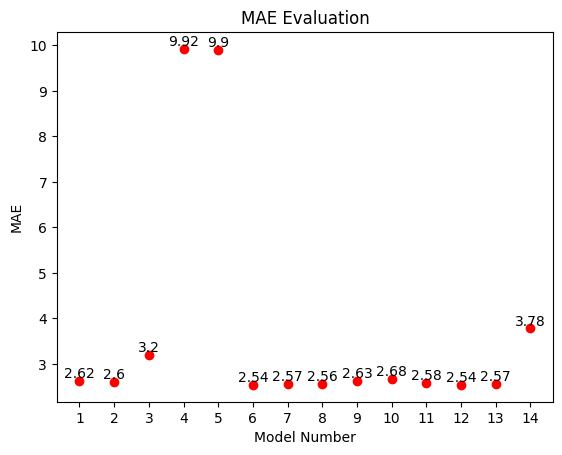

In [48]:
Models = ("1","2","3","4","5","6","7","8","9","10","11","12","13","14")
Mae = (2.62,2.60,3.2,9.92,9.9,2.54,2.57,2.56,2.63,2.68,2.58,2.54,2.57,3.78)

# MAE Evaluation
plt.scatter(Models, Mae, color="red")
plt.title("MAE Evaluation")
plt.xlabel("Model Number")
plt.ylabel("MAE")

for (xi, yi) in zip(Models,Mae):
    plt.text(xi, yi, yi, va='bottom', ha='center')

plt.show()
